In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from scipy import signal
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [50]:
def mark_label(zz):
    var = np.var(zz, axis=0)
    if var[0] > var[1]:
        z = np.hstack((zz[:, [1]], -zz[:, [0]]))
    else:
        z = zz.copy()
    y = np.zeros(z.shape[0])
    middle = (z[:, 1].max() + z[:, 1].min()) / 2
    upper_idx = z[:, 1] > middle
    left, right = z[upper_idx, 0].min(), z[upper_idx, 0].max()
    ll = (2 * left + right) / 3
    rr = (left + 2 * right) / 3
    y[np.bitwise_and(upper_idx, z[:, 0] < rr)] = 2
    y[np.bitwise_and(upper_idx, z[:, 0] < ll)] = 1
    y[np.bitwise_and(upper_idx, z[:, 0] >= rr)] = 3
    return y

In [51]:
def visualize(z_pred, y, method):
    for i in range(4):
        idx = (y == i)
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

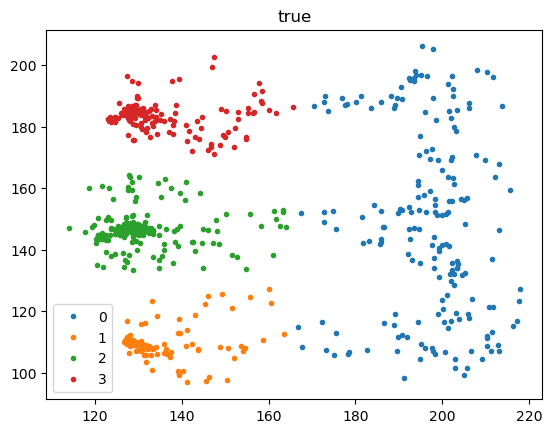

In [52]:
visualize(z_true, mark_label(z_true), 'true')

67


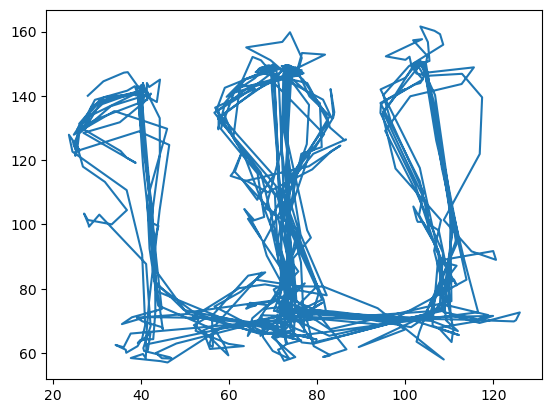

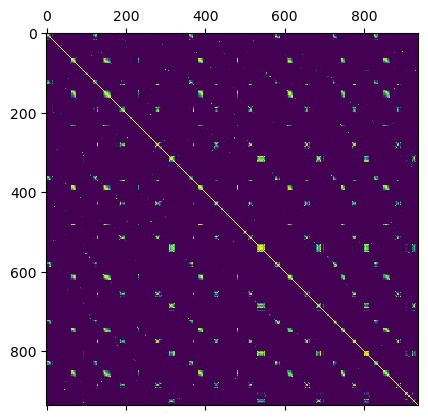

In [117]:
mouse_name = 'Bon'
day = 4
epoch = 4

z_true, spikes = datasets.hc_6(mouse_name, day, epoch)
n_points, d_latent = z_true.shape
print(spikes.shape[1])
plt.plot(z_true[:, 0], z_true[:, 1])
cov_true = utils.kernel_cov_generator(z_true)
plt.matshow(cov_true)
# x = spikes**0.1
x = signal.convolve(spikes, np.ones((20, 1))/20, 'same')
y = mark_label(z_true)

0.6265104107406986

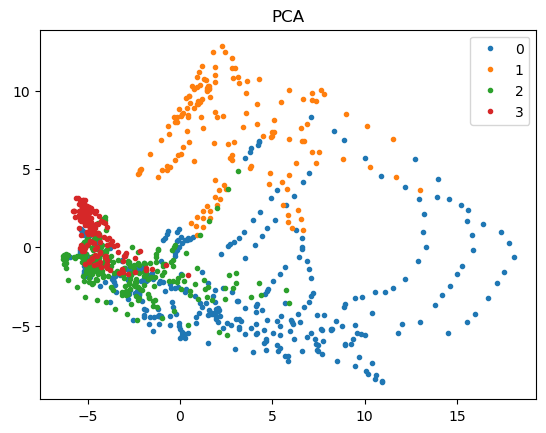

In [118]:
z_pca = PCA(n_components=d_latent).fit_transform(x)
visualize(z_pca, y, 'PCA')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_pca, y, cv=5)
scores.mean()

0.7929514165434066

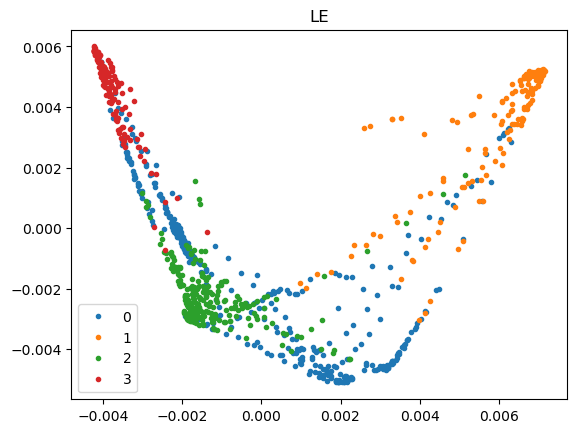

In [119]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
visualize(z_le, y, 'LE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_le, y, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


0.7759415178063489

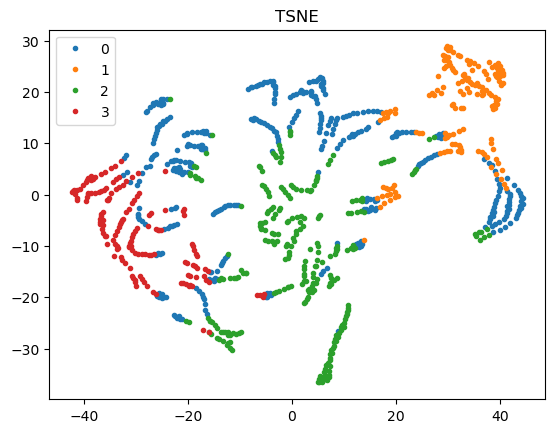

In [120]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
visualize(z_tsne, y, 'TSNE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_tsne, y, cv=5)
scores.mean()

0.638417339856639

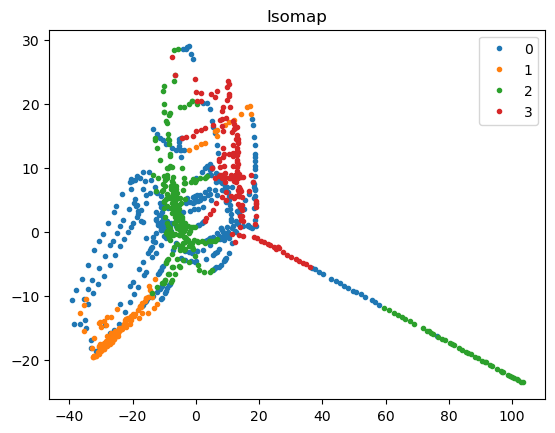

In [121]:
z_isomap = Isomap(n_components=d_latent).fit_transform(x)
visualize(z_isomap, y, 'Isomap')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_isomap, y, cv=5)
scores.mean()

0.7408123791102514

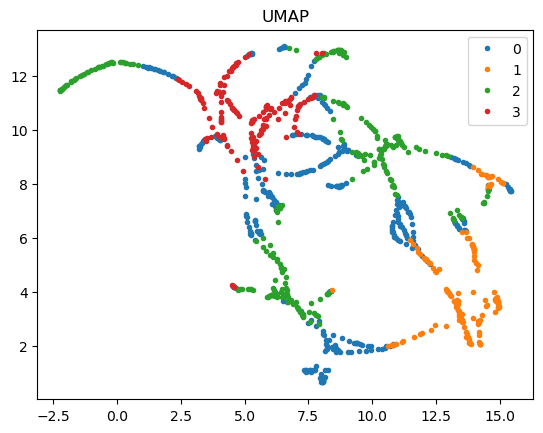

In [122]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
visualize(z_umap, y, 'UMAP')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_umap, y, cv=5)
scores.mean()

0.5711229946524063

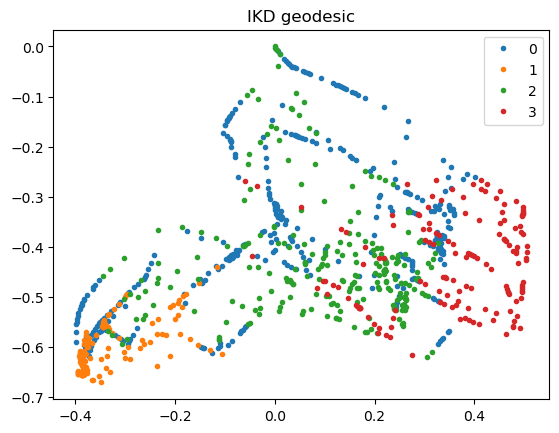

In [126]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 1e-3] = 1e-3
np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
np.fill_diagonal(corr_samp_th, 1)
# plt.matshow(corr_samp_th)

a = -np.log(corr_samp_th)
a_new = np.zeros((n_points, n_points))
np.fill_diagonal(a, 1e5)
for i in range(n_points):
    idx = np.argpartition(a[i], 10)[:10]
    a_new[i, idx] = a[i, idx]
    a_new[idx, i] = a[idx, i]
d = shortest_path(csr_matrix(a_new), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
visualize(z_ikd, y, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, y, cv=5)
scores.mean()

 /scratch/4953720.sched-torque.pace.gatech.edu/ipykernel_87287/3434199497.py:1: RuntimeWarning:invalid value encountered in power


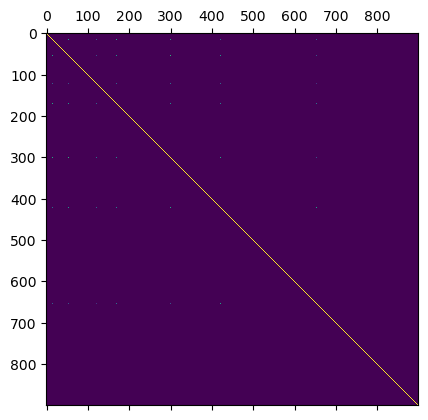

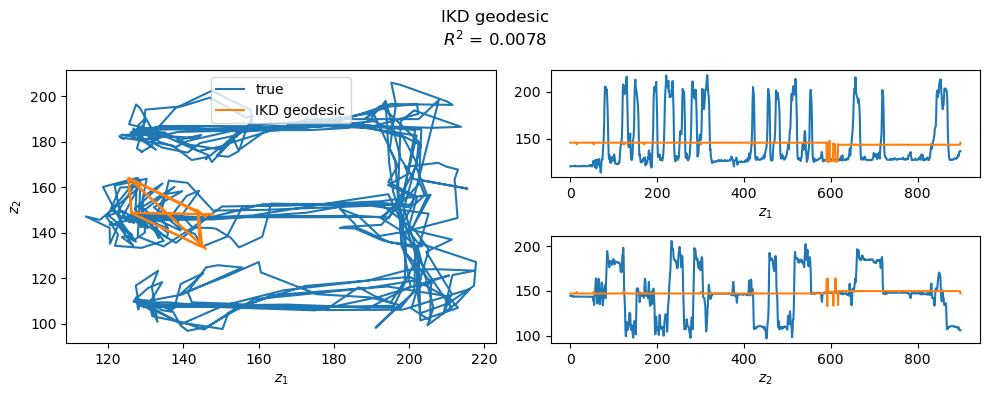

In [116]:
corr_samp = np.corrcoef(x**0.1)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 1e-3] = 1e-3
np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
np.fill_diagonal(corr_samp_th, 1)
plt.matshow(corr_samp_th)

a = -np.log(corr_samp_th)
a_new = np.zeros((n_points, n_points))
np.fill_diagonal(a, 1e5)
for i in range(n_points):
    idx = np.argpartition(a[i], 20)[:20]
    a_new[i, idx] = a[i, idx]
    a_new[idx, i] = a[idx, i]
d = shortest_path(csr_matrix(a_new), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD geodesic')

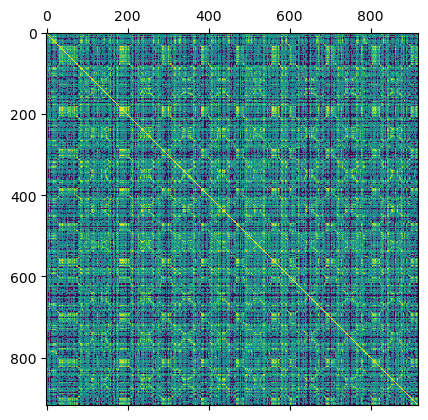

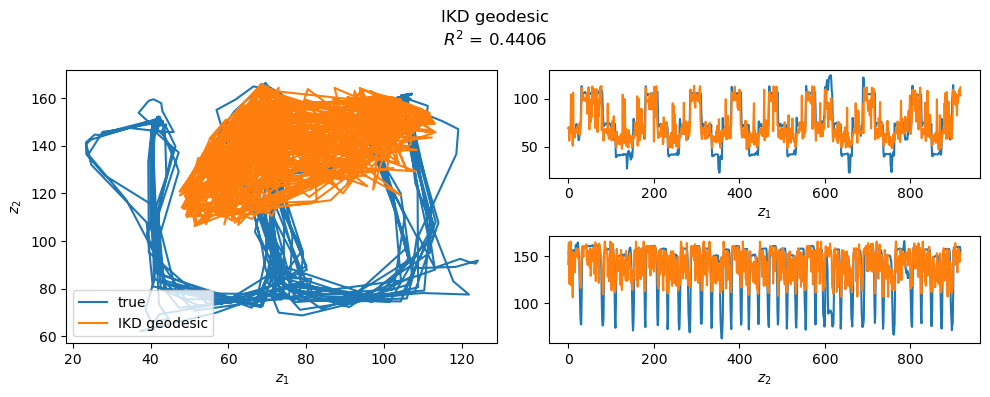

In [281]:
corr_samp = np.corrcoef(x**0.1)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 0.3] = 1e-3
np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
np.fill_diagonal(corr_samp_th, 1)
plt.matshow(corr_samp_th)

d = shortest_path(csr_matrix(-np.log(corr_samp_th)), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
# utils.median_filter()
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD geodesic')

In [57]:
day_dict = {'Bon': [3, 4, 5, 6, 7, 8, 9, 10],
    'Cor': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Con': [1, 2, 3, 4, 5, 6],
    'Dud': [1, 2, 3, 4, 5, 6],
    'Eig': [1, 2, 3, 4, 5, 6, 7],
    'Fiv': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Fra': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Mil': [1, 2, 3, 4, 5],
    'Ten': [1, 2, 3, 4, 5, 6, 7]}

In [231]:
df = pd.DataFrame(columns=['$R^2$', 'mouse_name', 'day', 'epoch', 'method'])

In [232]:
n = 0
for mouse_name in ['Bon', 'Cor', 'Con', 'Dud', 'Eig', 'Fiv', 'Fra', 'Mil', 'Ten']:
    for day in day_dict[mouse_name]:
        for epoch in [2, 4]:
            z_true, spikes = datasets.hc_6(mouse_name, day, epoch)
            n_points, d_latent = z_true.shape
#             cov_true = utils.kernel_cov_generator(z_true, variance=variance, length_scale=length_scale)

            x = spikes**0.1
    
            z_pca = PCA(n_components=d_latent).fit_transform(x)
            df.loc[n] = [r2_score(z_true, utils.align(z_true, z_pca)), mouse_name, day, epoch, 'PCA']
            n += 1
            
            z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
            df.loc[n] = [r2_score(z_true, utils.align(z_true, z_le)), mouse_name, day, epoch, 'LE']
            n += 1
            
#             z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(spikes)
#             df.loc[n] = [r2_score(z_true, utils.align(z_true, z_tsne)), mouse_name, day, epoch, 'TSNE']
#             n += 1
            
            z_isomap = Isomap(n_components=d_latent).fit_transform(x)
            df.loc[n] = [r2_score(z_true, utils.align(z_true, z_isomap)), mouse_name, day, epoch, 'Isomap']
            n += 1
            
#             z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(spikes)
#             df.loc[n] = [r2_score(z_true, utils.align(z_true, z_umap)), mouse_name, day, epoch, 'UMAP']
#             n += 1
            
            corr_samp = np.corrcoef(x)
            corr_samp_th = corr_samp.copy()
            corr_samp_th[corr_samp_th <= 1e-3] = 1e-3
            np.nan_to_num(corr_samp_th, copy=False, nan=1e-3)
            np.fill_diagonal(corr_samp_th, 1)

            a = -np.log(corr_samp_th)
            np.fill_diagonal(a, 1e5)
            
            n_neighbors = 30
            while True:
                a_new = np.zeros((n_points, n_points))
                for i in range(n_points):
                    idx = np.argpartition(a[i], n_neighbors)[:n_neighbors]
                    a_new[i, idx] = a[i, idx]
                    a_new[idx, i] = a[idx, i]
                d = shortest_path(csr_matrix(a_new), directed=False)
                np.isnan(np.array([np.nan, 3])).sum() > 0
                if np.isinf(d).sum() > 0:
                    n_neighbors += 5
                else:
                    break
            corr_geodesic = np.exp(-d)

            z_ikd = core.ikd(corr_geodesic, d_latent)

            df.loc[n] = [r2_score(z_true, utils.align(z_true, z_ikd)), mouse_name, day, epoch, 'IKD']
            n += 1
        print(mouse_name, day)

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Bon 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Bon 4
Bon 5
Bon 6
Bon 7
Bon 8
Bon 9
Bon 10
Cor 1


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountere

Cor 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Cor 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountere

Cor 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Cor 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Cor 6


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected com

Cor 7


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Cor 8


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 13 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 16 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Cor 9


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Con 1
Con 2
Con 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Con 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Con 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountere

Con 6


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Dud 1


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 15 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 20 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

Dud 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 22 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 43 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Dud 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 37 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 34 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

Dud 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 19 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity

Dud 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Dud 6
Eig 1
Eig 2
Eig 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Eig 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Eig 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountere

Eig 6


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 16 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 17 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Eig 7


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Fiv 1


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fiv 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected com

Fiv 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 22 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fiv 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected com

Fiv 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 23 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fiv 6


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Fiv 7


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fiv 8


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 15 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fiv 9


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:Graph is not fully connected, spectral embedding may not work as expected.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 36 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/li

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:Graph is not fully connected, spectral embedding may not work as expected.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 39 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/li

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEffic

Fra 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Fra 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive

Fra 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive

Fra 5
Fra 6
Fra 7


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive

Fra 8


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

Fra 9


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive

Fra 10


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Fra 11
Mil 1


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Mil 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Mil 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Mil 4


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/env

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 18 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsit

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Mil 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Ten 1


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Ten 2
Ten 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:invalid value encountered in true_divide


Ten 4
Ten 5
Ten 6
Ten 7


In [263]:
df[df.mouse_name == 'Bon']

,$R^2$,mouse_name,day,epoch,method
0,0.242531,Bon,3,2,PCA
1,0.234525,Bon,3,2,LE
2,0.240583,Bon,3,2,Isomap
3,0.250846,Bon,3,2,IKD
4,0.313637,Bon,3,4,PCA
...,...,...,...,...,...
59,0.413004,Bon,10,2,IKD
60,0.465081,Bon,10,4,PCA
61,0.520694,Bon,10,4,LE
62,0.515938,Bon,10,4,Isomap


[Text(0.5, 0, '')]

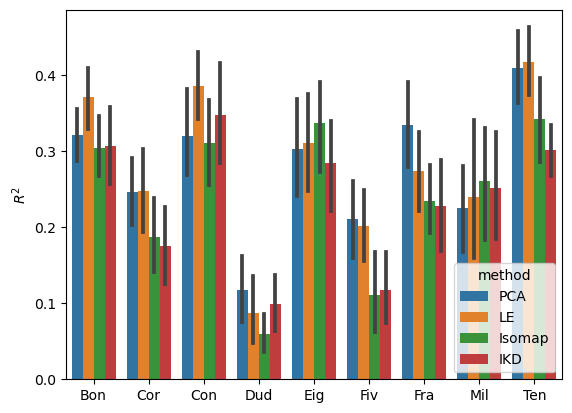

In [234]:
plt.figure()
sns.barplot(x='mouse_name', y='$R^2$', hue='method', data=df).set(xlabel=None)